## Predicting Bank Term Deposit Subscriptions Using the Bank Marketing Dataset
---
Group 3

### Introduction
This project aims to predict whether a client will subscribe to a term deposit based on the data from a Portuguese banking institution's marketing campaigns. The dataset bank-full.csv contains information on client demographics, bank details, and the outcome of previous marketing efforts.  

We will perform the following steps:
1. [Importing Libraries](#1.-importing-libraries)
2. [Loading the Dataset](#2.-loading-the-dataset)
3. [Exploratory Data Analysis](#3.-exploratory-data-analysis)
4. [Data Preprocessing](#4.-data-preprocessing)
5. [Feature Engineering](#5.-feature-engineering)
6. [Feature Selection](#6.-feature-selection)
7. [Model Building and Hyperparameter Tuning](#7.-model-building-and-hyperparameter-tuning-with-smote-in-cross-validation)
8. [Evaluating Models on Test Set](#8.-evaluating-models-on-test-set)
9. [Interpretation of Results](#9.-interpretation-of-results)
10. [Conclusion](#10.-conclusion)

Contribute by Group 3

Group Member: Zhong Hao,Wen Xingdi,Li Xinzhu,Zhang Yichuan

### 1. Importing Libraries
First, we need to import the necessary Python libraries for data manipulation, visualisation, and modeling.

In [58]:
# data manipulation and analysis
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import matthews_corrcoef, make_scorer, confusion_matrix, classification_report

# handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Loading the Dataset
We load the dataset bank-full.csv.

Data cleaning

In [59]:
# load the dataset
data = pd.read_csv('D:/NTU_Data_Mining/bank-full.csv', sep=';')

# display the first few rows
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [60]:
print(data.dtypes)


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


In [61]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [62]:
# Display the number of duplicate rows
print(data.duplicated().sum())

# Display all the duplicate rows
print(data[data.duplicated()])

0
Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y]
Index: []


In [63]:
unknown_counts = {}
for column in data.columns:
    if data[column].dtype == 'object':  # Only check columns of type string
        unknown_count = (data[column] == 'unknown').sum()
        if unknown_count > 0:
            unknown_counts[column] = unknown_count

print("Number of 'unknown' values:")
for column, count in unknown_counts.items():
    print(f"{column}: {count}")

Number of 'unknown' values:
job: 288
education: 1857
contact: 13020
poutcome: 36959


In [64]:
data['job'] = data['job'].replace('unknown', 'other')

In [65]:
data['education'] = data['education'].replace('unknown', 'other')

In [66]:
data['contact'] = data['contact'].replace('unknown', 'other')

In [67]:
# Replace 'unknown' in the poutcome column with 'NPR'
data['poutcome'] = data['poutcome'].replace('unknown', 'NPR')

# Check the updated category distribution
print(data['poutcome'].value_counts())

poutcome
NPR        36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64


The above is the basic part of data cleaning

In [68]:
df=data.copy()

In [69]:
df.tail(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45201,53,management,married,tertiary,no,583,no,no,cellular,17,nov,226,1,184,4,success,yes
45202,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,224,1,-1,0,NPR,yes
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,NPR,yes
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,failure,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,NPR,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NPR,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NPR,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NPR,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [70]:
df.head(15) 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,other,5,may,261,1,-1,0,NPR,no
1,44,technician,single,secondary,no,29,yes,no,other,5,may,151,1,-1,0,NPR,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,other,5,may,76,1,-1,0,NPR,no
3,47,blue-collar,married,other,no,1506,yes,no,other,5,may,92,1,-1,0,NPR,no
4,33,other,single,other,no,1,no,no,other,5,may,198,1,-1,0,NPR,no
5,35,management,married,tertiary,no,231,yes,no,other,5,may,139,1,-1,0,NPR,no
6,28,management,single,tertiary,no,447,yes,yes,other,5,may,217,1,-1,0,NPR,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,other,5,may,380,1,-1,0,NPR,no
8,58,retired,married,primary,no,121,yes,no,other,5,may,50,1,-1,0,NPR,no
9,43,technician,single,secondary,no,593,yes,no,other,5,may,55,1,-1,0,NPR,no


# Exploratory Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
                age        balance           day      duration      campaign  \
count  45211.0

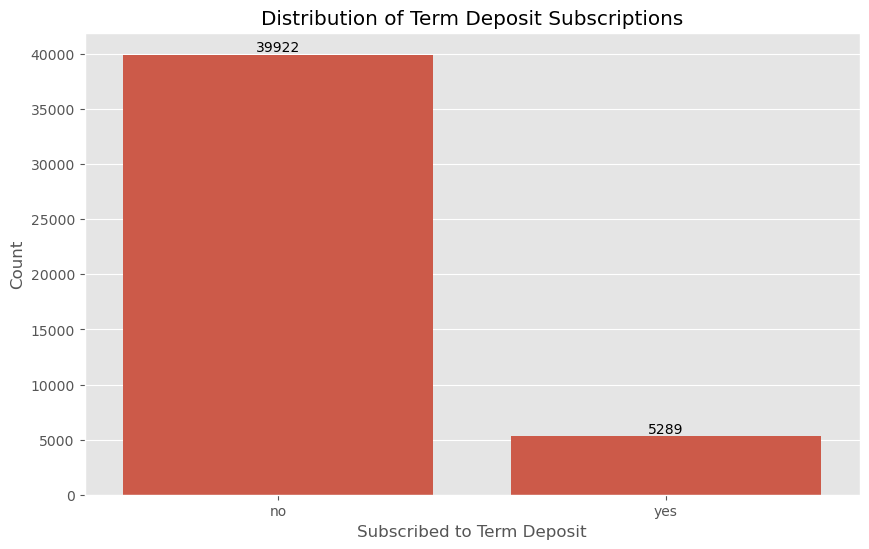

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
# Set custom warm color palette
warm_palette = sns.color_palette("YlOrRd", n_colors=10)
sns.set_palette(warm_palette)

# Set style
plt.style.use('ggplot')


# 1. Data overview
print(df.info())
print(df.describe())

# 2. Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='y', data=df)
plt.title('Distribution of Term Deposit Subscriptions')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
for i in plt.gca().containers:
    plt.gca().bar_label(i)
plt.show()


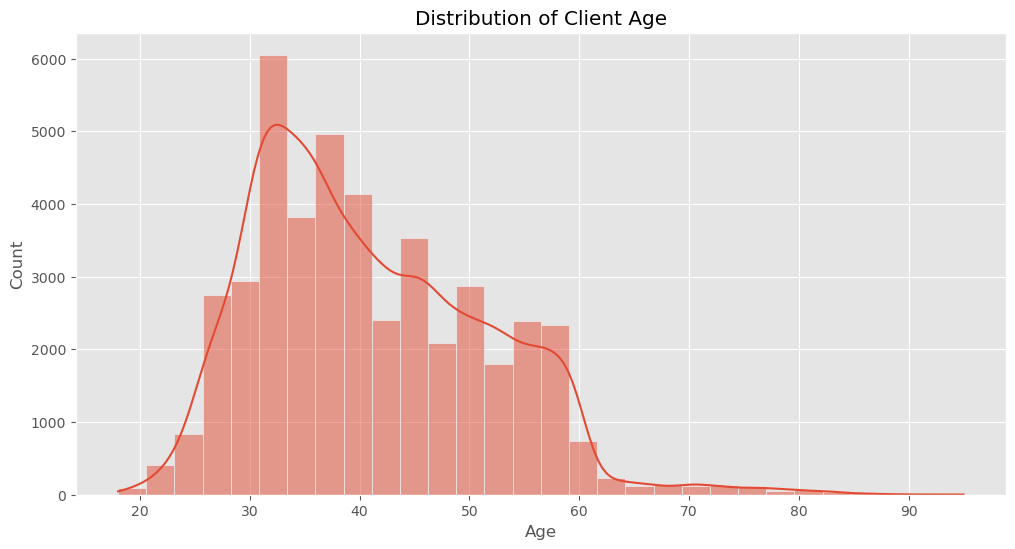

In [72]:
# 3. Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['age'], kde=True, bins=30)
plt.title('Distribution of Client Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()



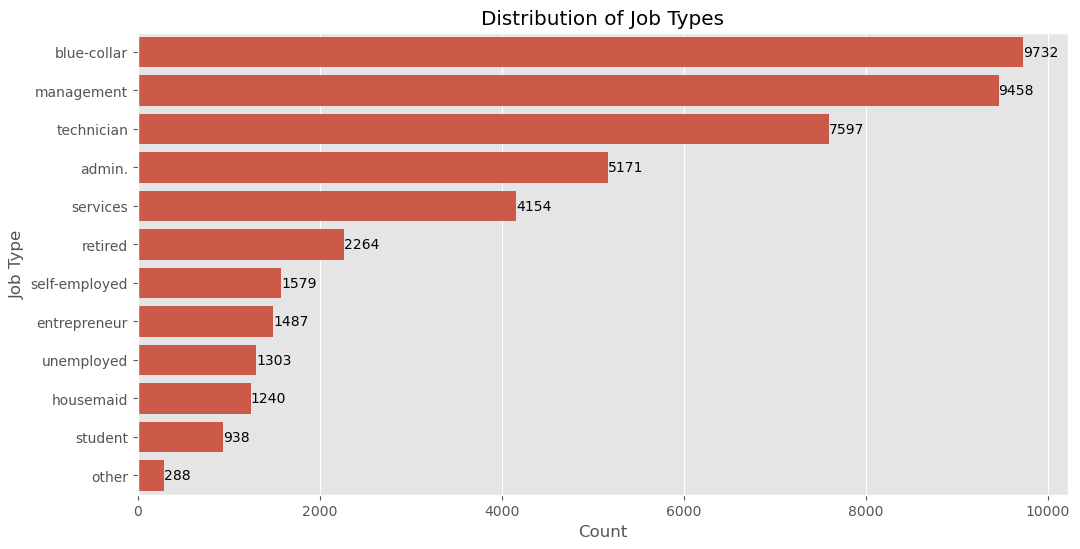

In [73]:
# 4. Job distribution
plt.figure(figsize=(12, 6))
job_order = df['job'].value_counts().index
sns.countplot(y='job', data=df, order=job_order)
plt.title('Distribution of Job Types')
plt.xlabel('Count')
plt.ylabel('Job Type')
for i in plt.gca().containers:
    plt.gca().bar_label(i)
plt.show()



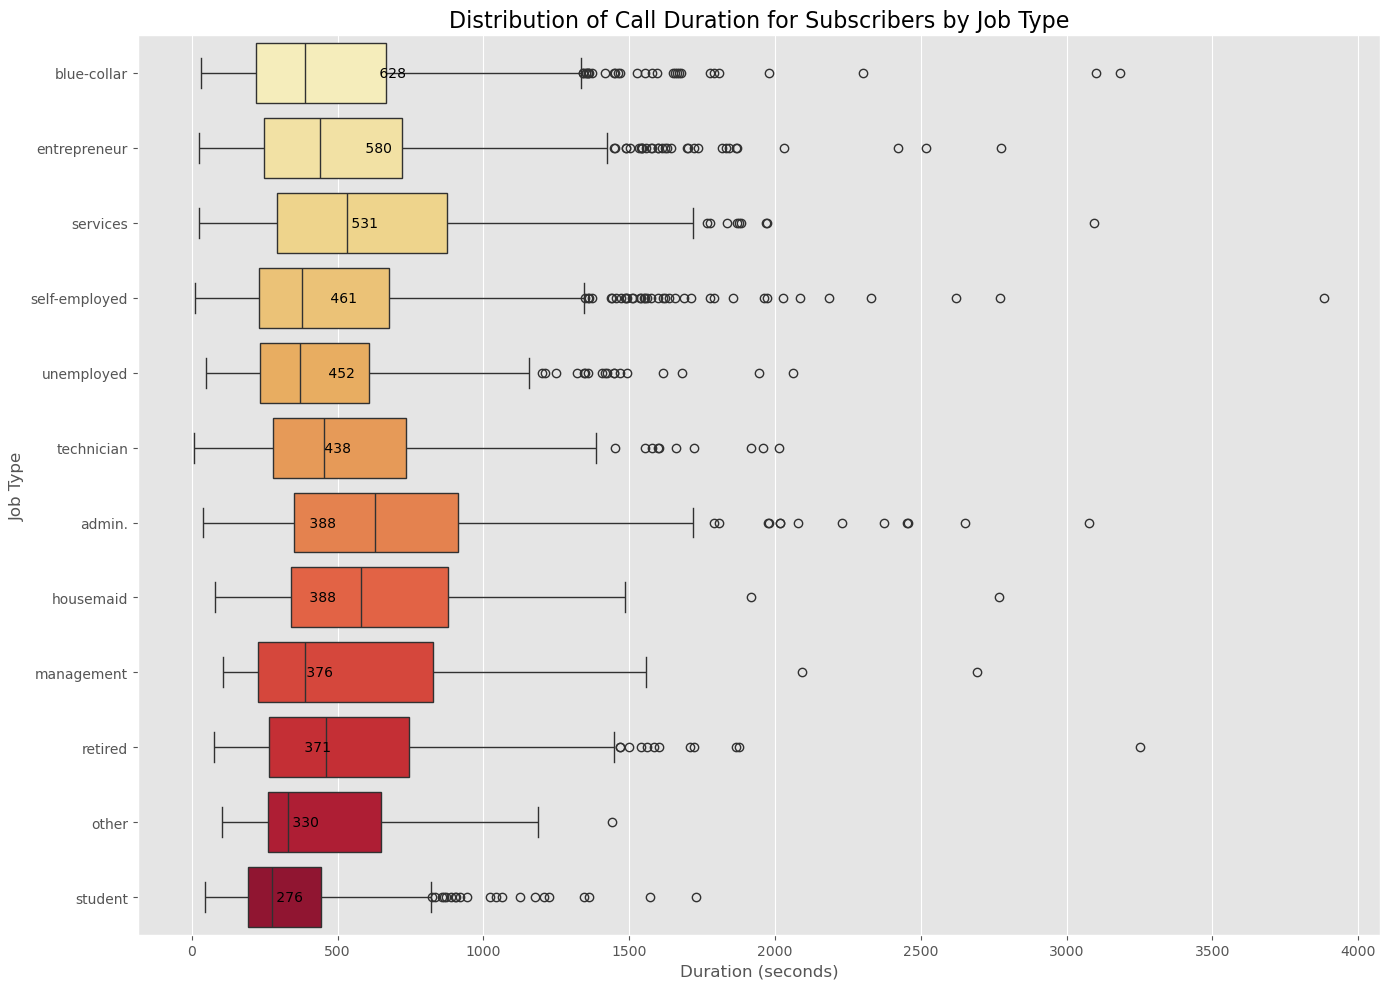

                count        mean         std    min     25%    50%     75%  \
job                                                                           
admin.          631.0  503.114105  396.707637   30.0  219.00  388.0  666.00   
blue-collar     708.0  675.355932  416.893863   39.0  351.75  628.0  911.50   
entrepreneur    123.0  642.991870  410.225678   79.0  341.50  580.0  879.00   
housemaid       109.0  552.688073  440.432462  105.0  226.00  388.0  828.00   
management     1301.0  499.620292  378.245427   11.0  229.00  376.0  676.00   
other            34.0  476.205882  305.452251  104.0  261.25  330.5  649.75   
retired         516.0  460.325581  314.316881   49.0  233.00  371.0  607.75   
self-employed   187.0  584.042781  444.130476   76.0  266.00  461.0  745.50   
services        369.0  621.804878  422.593789   25.0  291.00  531.0  874.00   
student         269.0  368.200743  269.946271   46.0  194.00  276.0  444.00   
technician      840.0  539.433333  389.682164   23.0

In [74]:
subscribers = df[df['y'] == 'yes']

# Set up the plot
plt.figure(figsize=(14, 10))

# Create the boxplot
sns.boxplot(y='job', x='duration', data=subscribers, orient='h', palette='YlOrRd')

# Customize the plot
plt.title('Distribution of Call Duration for Subscribers by Job Type', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Job Type', fontsize=12)

# Sort the job types by median duration
job_order = subscribers.groupby('job')['duration'].median().sort_values(ascending=False).index
plt.gca().set_yticklabels(job_order)

# Add median values to the plot
medians = subscribers.groupby('job')['duration'].median().sort_values(ascending=False)
for i, median in enumerate(medians):
    plt.text(median, i, f' {median:.0f}', va='center')

plt.tight_layout()
plt.show()

# Print some summary statistics
print(subscribers.groupby('job')['duration'].describe())

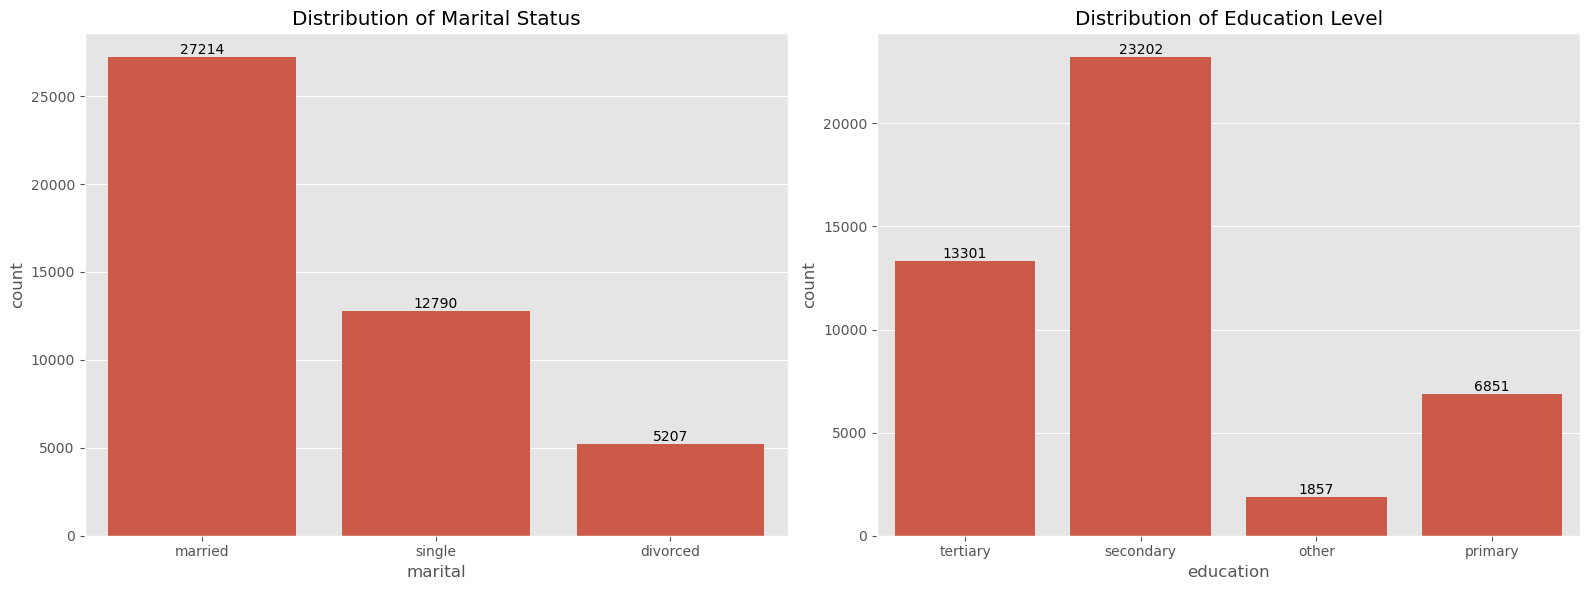

In [75]:
# 5. Marital status and education level
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='marital', data=df, ax=ax1)
ax1.set_title('Distribution of Marital Status')
sns.countplot(x='education', data=df, ax=ax2)
ax2.set_title('Distribution of Education Level')
for i in ax1.containers:
    ax1.bar_label(i)
for i in ax2.containers:
    ax2.bar_label(i)
plt.tight_layout()
plt.show()



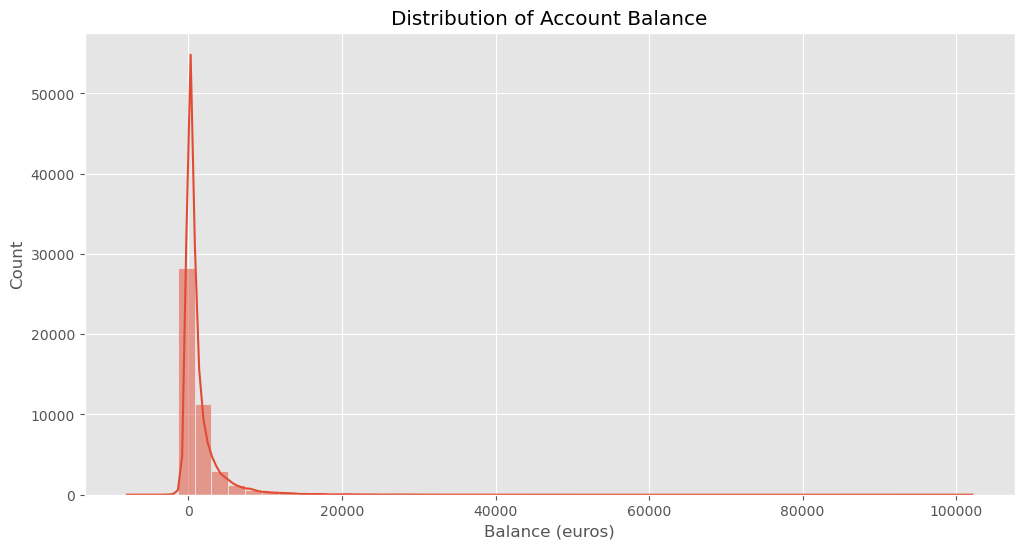

In [76]:
# 6. Account balance distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['balance'], kde=True, bins=50)
plt.title('Distribution of Account Balance')
plt.xlabel('Balance (euros)')
plt.ylabel('Count')
plt.show()



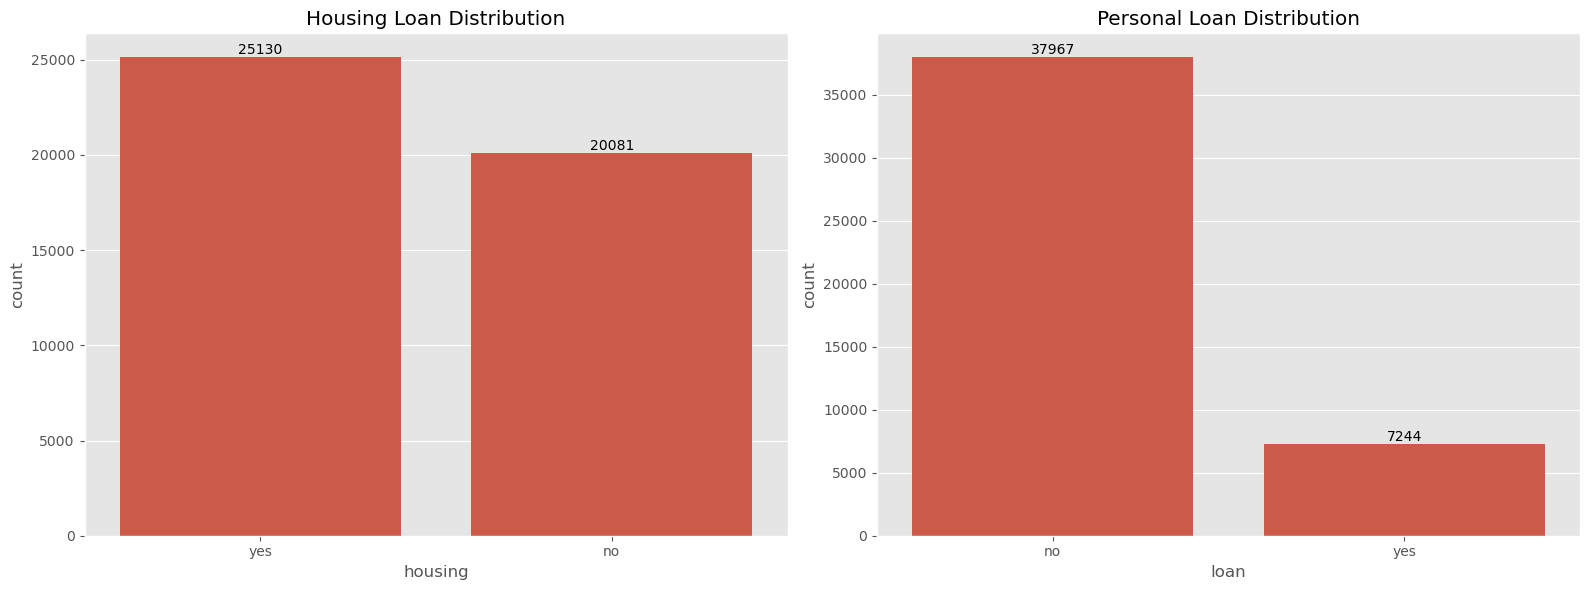

In [77]:
# 7. Loan status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='housing', data=df, ax=ax1)
ax1.set_title('Housing Loan Distribution')
sns.countplot(x='loan', data=df, ax=ax2)
ax2.set_title('Personal Loan Distribution')
for i in ax1.containers:
    ax1.bar_label(i)
for i in ax2.containers:
    ax2.bar_label(i)
plt.tight_layout()
plt.show()



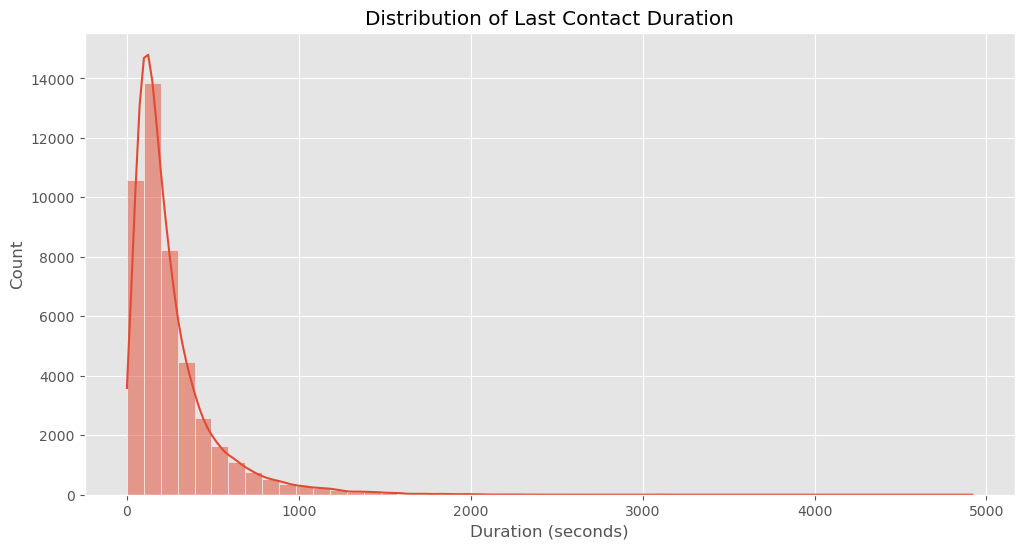

In [78]:
# 8. Call duration distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['duration'], kde=True, bins=50)
plt.title('Distribution of Last Contact Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()



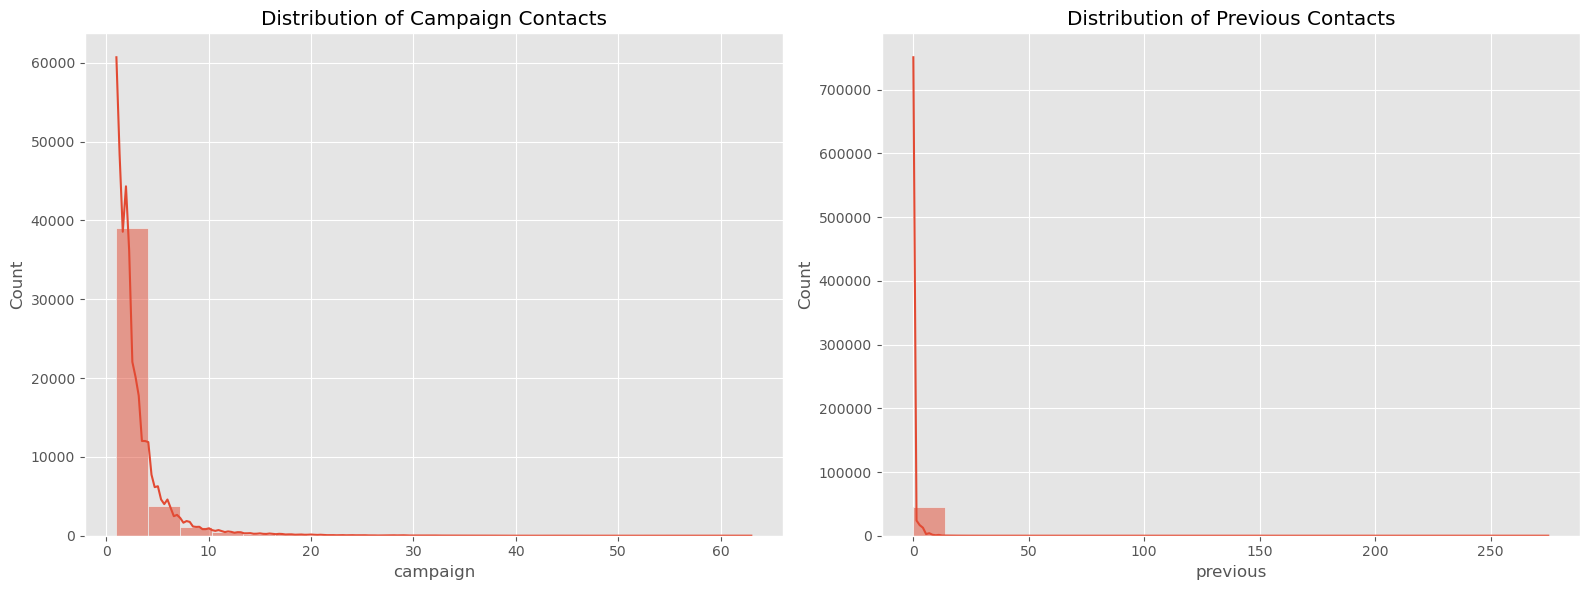

In [79]:
# 9. Marketing campaign analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['campaign'], kde=True, bins=20, ax=ax1)
ax1.set_title('Distribution of Campaign Contacts')
sns.histplot(df['previous'], kde=True, bins=20, ax=ax2)
ax2.set_title('Distribution of Previous Contacts')
plt.tight_layout()
plt.show()



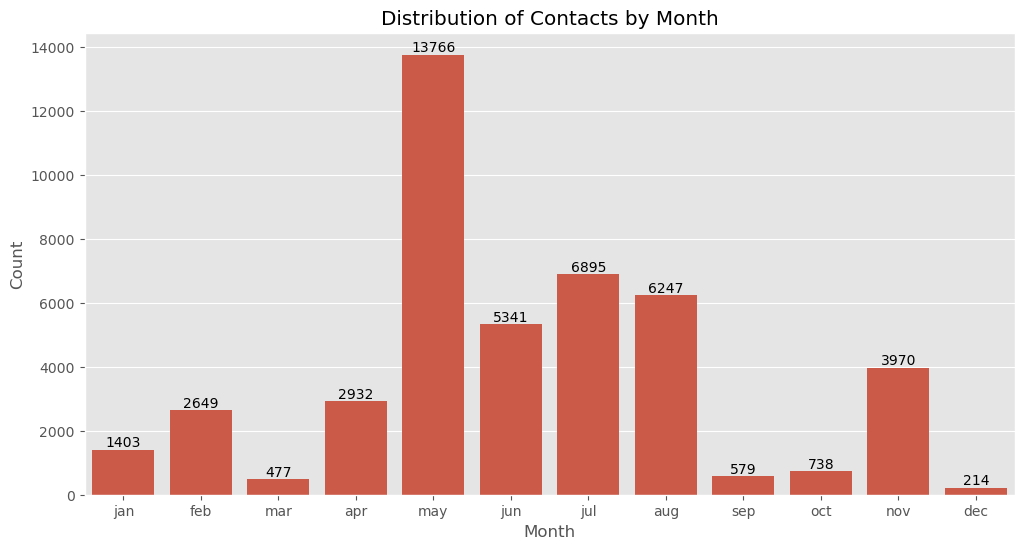

In [80]:
# 10. Month distribution
plt.figure(figsize=(12, 6))
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sns.countplot(x='month', data=df, order=month_order)
plt.title('Distribution of Contacts by Month')
plt.xlabel('Month')
plt.ylabel('Count')
for i in plt.gca().containers:
    plt.gca().bar_label(i)
plt.show()



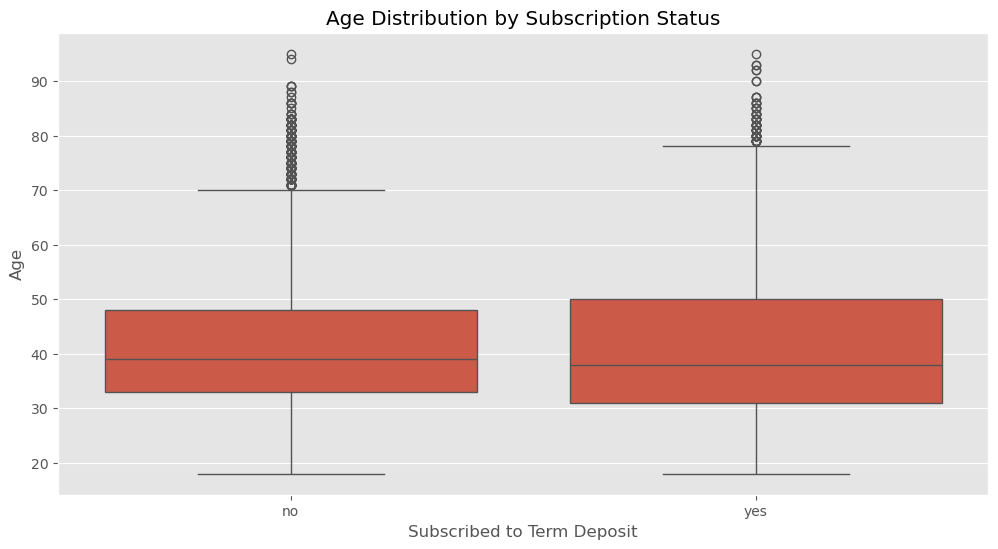

In [81]:
# 11. Relationship between age and subscription
plt.figure(figsize=(12, 6))
sns.boxplot(x='y', y='age', data=df)
plt.title('Age Distribution by Subscription Status')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Age')
plt.show()



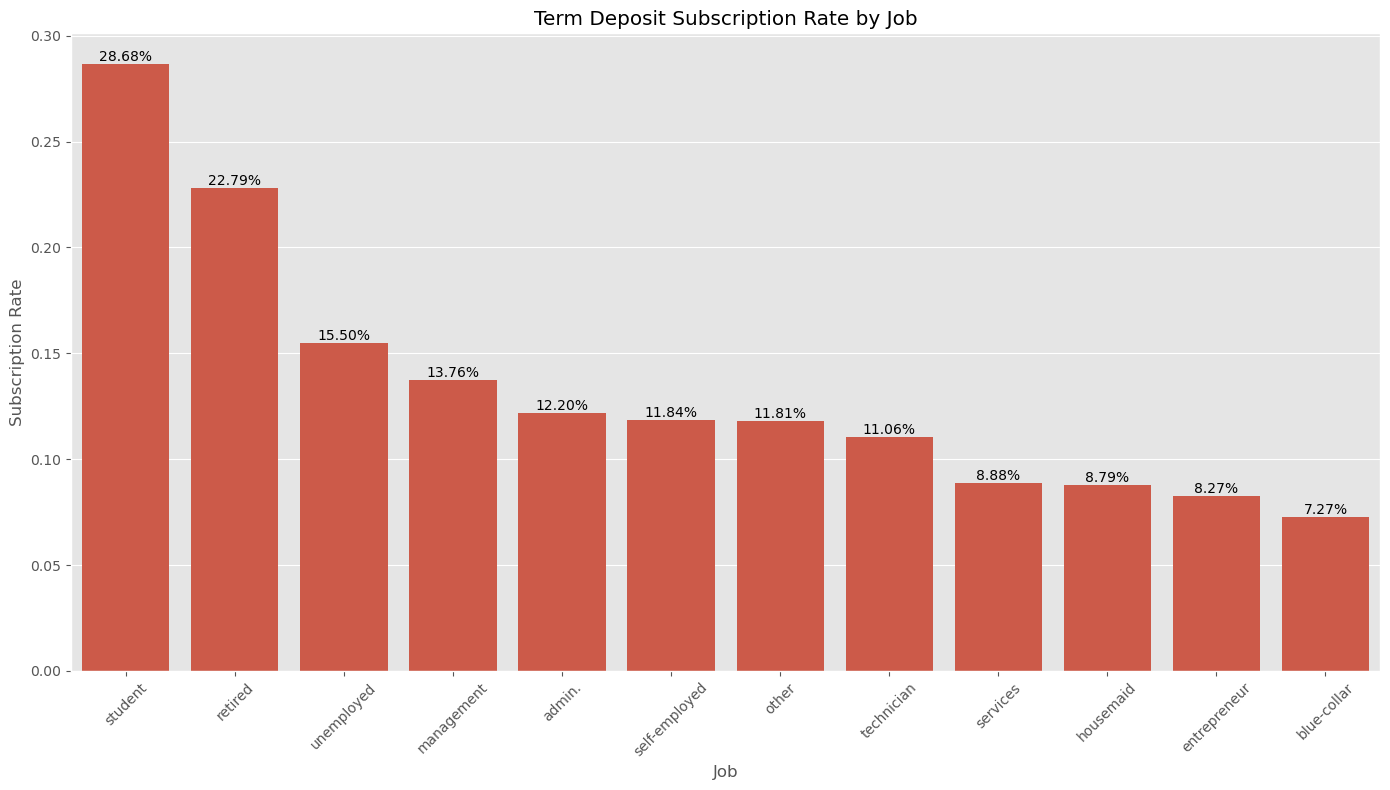

In [82]:
# 12. Relationship between job and subscription
plt.figure(figsize=(14, 8))
subscription_rate = df.groupby('job')['y'].value_counts(normalize=True).unstack()['yes'].sort_values(ascending=False)
sns.barplot(x=subscription_rate.index, y=subscription_rate.values)
plt.title('Term Deposit Subscription Rate by Job')
plt.xlabel('Job')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
for i, v in enumerate(subscription_rate.values):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()



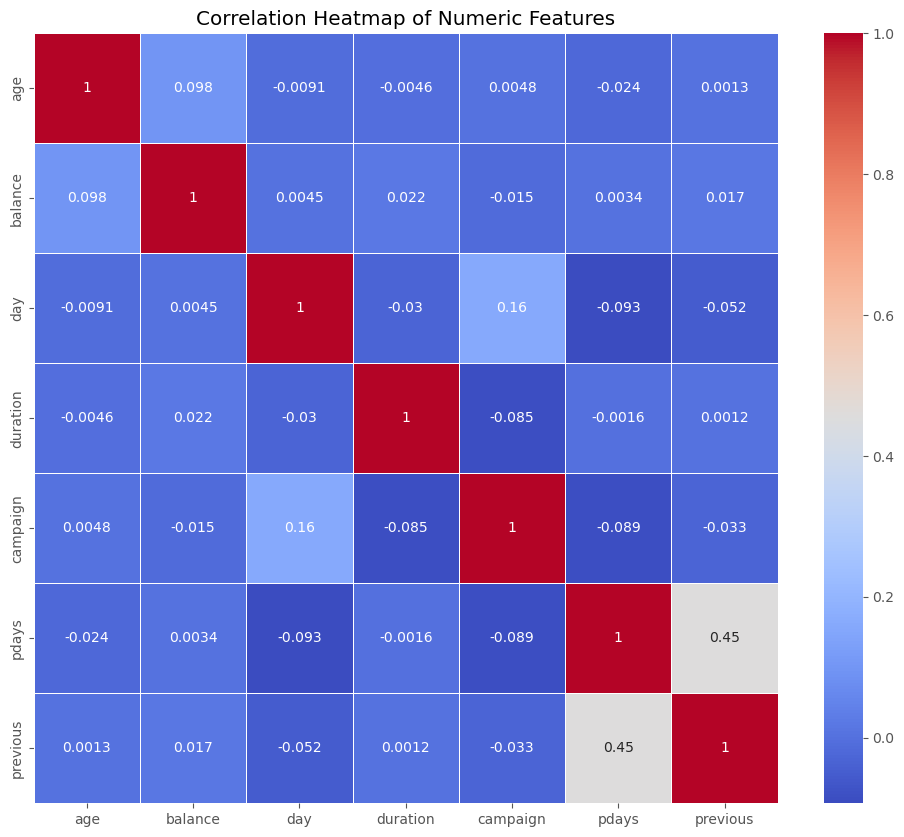

In [83]:
# 13. Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()



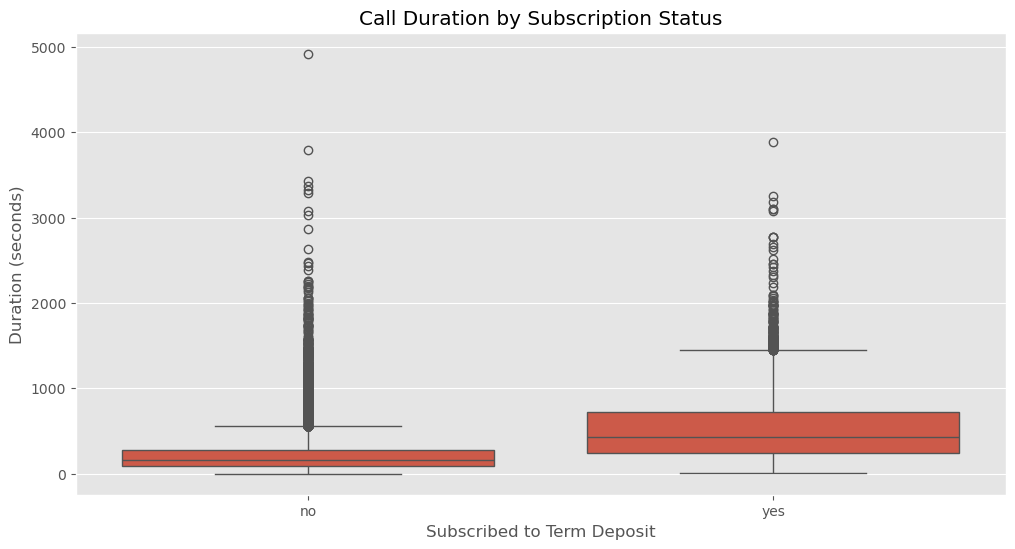

Exploratory Data Analysis Completed


In [84]:
# 14. Relationship between call duration and subscription
plt.figure(figsize=(12, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Call Duration by Subscription Status')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Duration (seconds)')
plt.show()

print("Exploratory Data Analysis Completed")

df.tail(15) 

# Preprocessing and Common function setting

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint, uniform
from xgboost import XGBClassifier

# ------------Data Splitting------------
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)




Training set shape: (36168, 16), Test set shape: (9043, 16)


In [86]:
# ------------Data Engineering------------
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_use):
        self.features_to_use = features_to_use
        self.original_columns = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        print(f"Starting feature engineering with features: {self.features_to_use}")
        
        if 1 in self.features_to_use:
            X['marital_hl_status'] = np.select(
                [
                    (X['marital'] == 'married') & (X['default'] == 'no'),
                    (X['marital'] == 'married') & (X['default'] == 'yes'),
                    (X['marital'] != 'married') & (X['default'] == 'no'),
                    (X['marital'] != 'married') & (X['default'] == 'yes')
                ],
                [0, 1, 2, 3],
                default=4
            )
        
        if 2 in self.features_to_use:
            def calc_comprehensive_efficiency(row):
                if row['poutcome'] == 'success':
                    base_efficiency = 1 / (row['duration'] + 1)
                elif row['poutcome'] == 'failure':
                    base_efficiency = -1 / (row['duration'] + 1)
                else:
                    base_efficiency = 0
                campaign_factor = 1 / (row['campaign'] + 1)
                previous_factor = np.log1p(row['previous']) / 10
                return base_efficiency * (1 + campaign_factor + previous_factor)
            
            X['communication_efficiency'] = X.apply(calc_comprehensive_efficiency, axis=1)
            X['communication_efficiency'] = X['communication_efficiency'].rank(method='dense', pct=True)
        
        if 3 in self.features_to_use:
            X['contact_efficiency'] = pd.factorize(X['contact'] + '_' + X['poutcome'])[0]
        
        if 4 in self.features_to_use:
            X['campaign_efficiency'] = X.apply(lambda row: row['campaign'] if row['previous'] == 0 
                                               else (row['campaign'] - row['previous']) / (row['previous'] + 1), axis=1)
        
        if 5 in self.features_to_use:
            X['financial_status'] = X.apply(lambda row: row['balance'] if (row['housing'] == 'no' and row['loan'] == 'no')
                                            else row['balance'] / ((row['housing'] == 'yes') + (row['loan'] == 'yes')), axis=1)
        
        if 6 in self.features_to_use:
            X['education_encoded'], _ = pd.factorize(X['education'])
            X['job_encoded'], _ = pd.factorize(X['job'])
            X['poutcome_encoded'], _ = pd.factorize(X['poutcome'])
            X['edu_job_outcome'] = X['education_encoded'] * X['job_encoded'] * (X['poutcome_encoded'] + 1)
            
            X['edu_job_outcome_rank'] = X['edu_job_outcome'].rank(method='dense', pct=True)
            X['edu_job_status'] = pd.cut(
                X['edu_job_outcome_rank'],
                bins=5,
                labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
            )
            X = X.drop(['education_encoded', 'job_encoded', 'poutcome_encoded', 'edu_job_outcome', 'edu_job_outcome_rank'], axis=1)
        
        return X

    def fit_transform(self, X, y=None):
        self.original_columns = X.columns
        return self.transform(X)

class UniversalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for column in X.columns:
            if X[column].dtype == 'object' or X[column].dtype.name == 'category':
                self.encoders[column] = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            else:
                self.encoders[column] = StandardScaler()
            self.encoders[column].fit(X[[column]])
        return self

    def transform(self, X):
        X_encoded = pd.DataFrame()
        for column in X.columns:
            if column in self.encoders:
                if isinstance(self.encoders[column], OneHotEncoder):
                    encoded = self.encoders[column].transform(X[[column]])
                    feature_names = self.encoders[column].get_feature_names_out([column])
                    encoded_df = pd.DataFrame(encoded, columns=feature_names, index=X.index)
                else:
                    encoded = self.encoders[column].transform(X[[column]])
                    encoded_df = pd.DataFrame(encoded, columns=[column], index=X.index)
                X_encoded = pd.concat([X_encoded, encoded_df], axis=1)
            else:
                X_encoded = pd.concat([X_encoded, X[column]], axis=1)
        return X_encoded


### Explaination of Engineered feature

According to the code, we can summarize the creation logic of the following 6 engineering features:

1. marital_hl_status:
This feature combines marital status and whether there is a record of default. It creates a categorical variable with the following categories:

- 0: married and no default

- 1: married and has defaulted

- 2: unmarried and no default

- 3: unmarried and has defaulted

- 4: other cases (default value)

2. communication_efficiency:
This feature takes into account the result of the last marketing campaign, call duration, number of marketing campaigns, and number of previous contacts.

- If the last result was successful, the efficiency is positive; if it failed, the efficiency is negative; otherwise it is zero.

- Efficiency is inversely proportional to the call duration, and is related to the number of marketing campaigns and the number of previous contacts.

- Finally, the results are sorted and converted to percentage rankings.

3. contact_efficiency:
Combine the contact method (contact) and the last marketing result (poutcome) into a new categorical feature.

4. campaign_efficiency:
Measures the efficiency of the current campaign relative to the previous campaign.
- If it is the first contact (previous = 0), the campaign value is used directly.
- Otherwise, (campaign - previous) / (previous + 1) is calculated to reflect the change in efficiency relative to the previous campaign.

5. financial_status:
Adjusts the balance according to whether the customer has a mortgage or personal loan.
- If there is neither a mortgage nor a personal loan, the balance is used directly.
- Otherwise, the balance is divided by the number of loan types (mortgage and personal loans) to reflect the financial status after taking into account liabilities.

6. edu_job_status:
This feature takes into account the impact of education level, job type, and previous marketing results.
- First, education, job, and poutcome are encoded.
- Then these codes are multiplied to create a composite score.
- This score is sorted and divided into 5 categories: Very Low, Low, Medium, High, Very High.

These engineered features are designed to capture multiple aspects of a customer, including personal circumstances, financial status, past marketing interaction history, and the combined impact of these factors to improve the model’s predictive power.

Starting feature engineering with features: [1, 2, 3, 4, 5, 6]


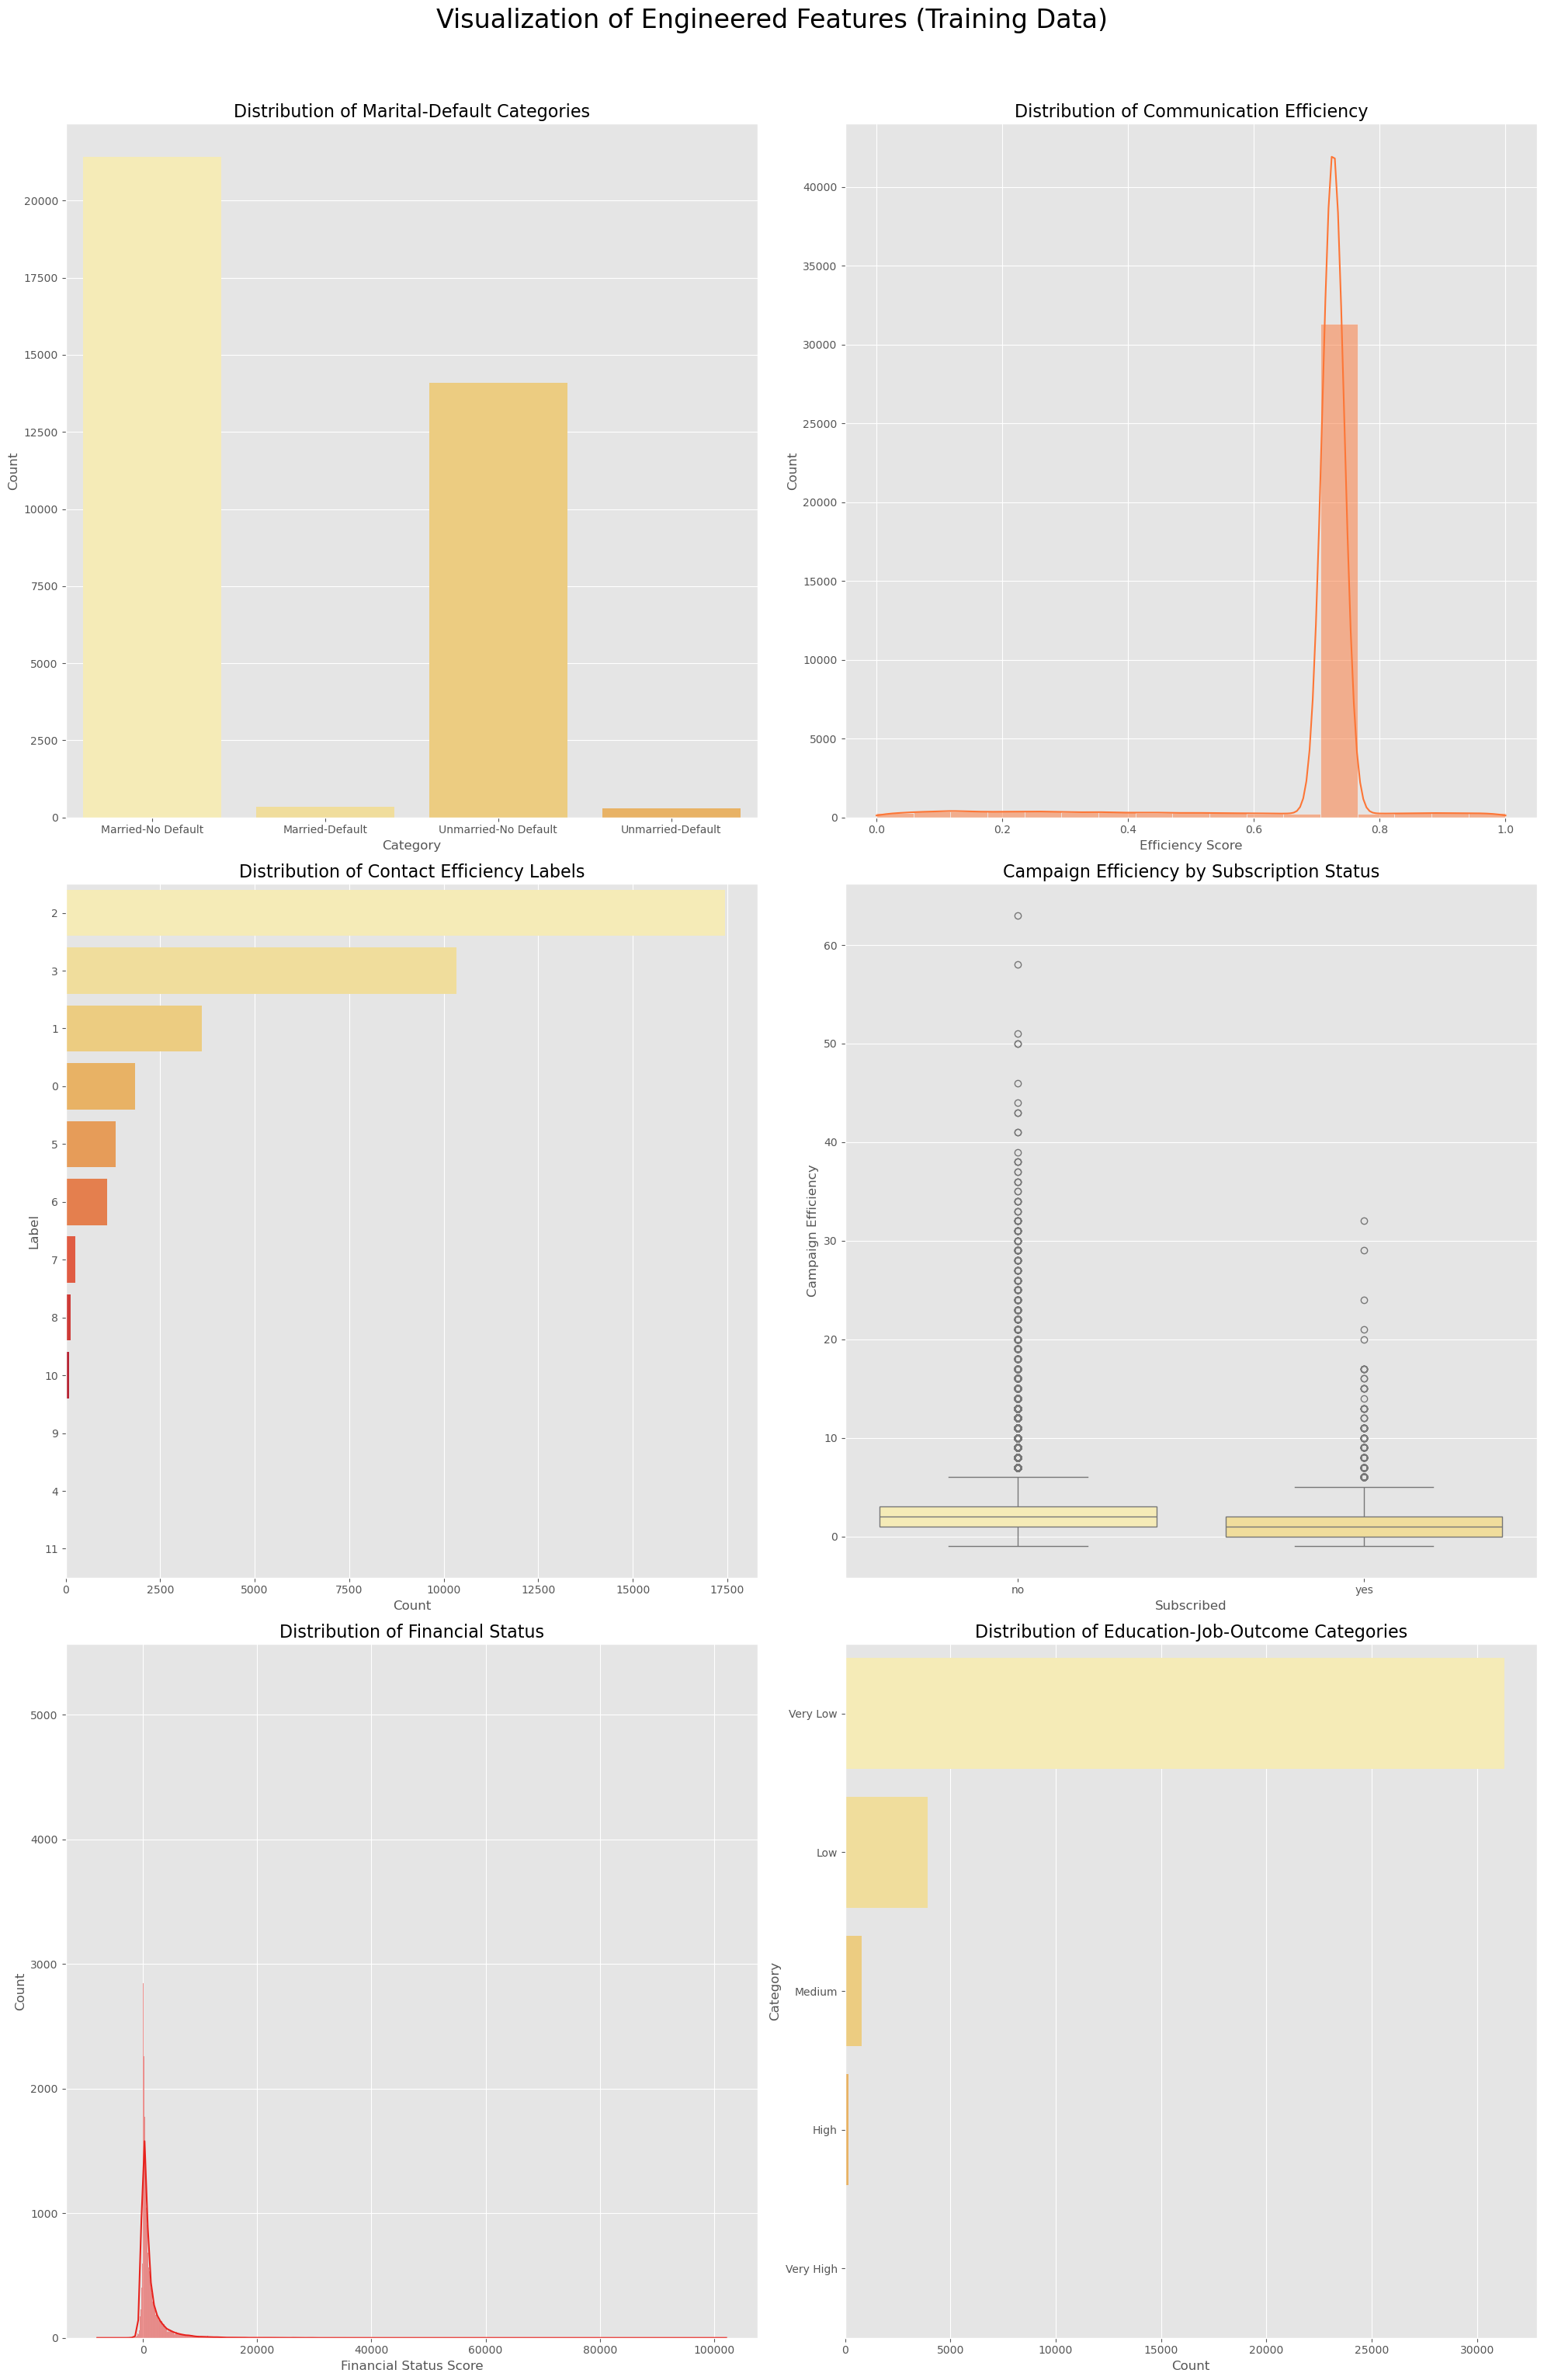

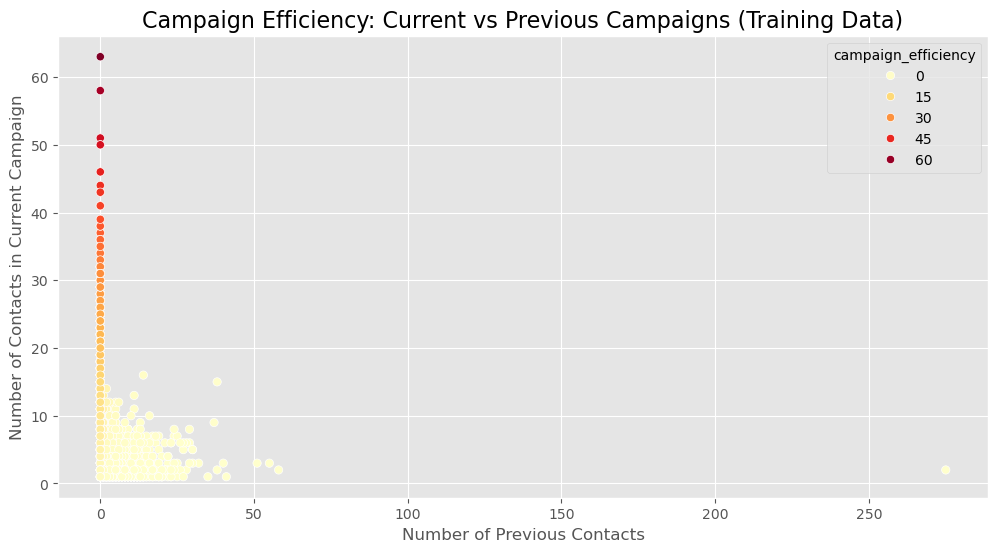

Visualization of Engineered Features Completed


In [87]:
# Apply feature engineering to training data
fe = FeatureEngineer(features_to_use=[1,2,3,4,5,6])
X_train_engineered = fe.fit_transform(X_train)

# Now we can visualize the engineered features
plt.style.use('ggplot')
colors = sns.color_palette("YlOrRd", n_colors=10)

fig, axes = plt.subplots(3, 2, figsize=(20, 30))
fig.suptitle('Visualization of Engineered Features (Training Data)', fontsize=24, y=1.02)

# 1. marital_hl_status
sns.countplot(x='marital_hl_status', data=X_train_engineered, ax=axes[0, 0], palette=colors)
axes[0, 0].set_title('Distribution of Marital-Default Categories', fontsize=16)
axes[0, 0].set_xlabel('Category', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].set_xticklabels(['Married-No Default', 'Married-Default', 'Unmarried-No Default', 'Unmarried-Default', 'Other'])

# 2. communication_efficiency
sns.histplot(X_train_engineered['communication_efficiency'], kde=True, ax=axes[0, 1], color=colors[5])
axes[0, 1].set_title('Distribution of Communication Efficiency', fontsize=16)
axes[0, 1].set_xlabel('Efficiency Score', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)

# 3. contact_efficiency
sns.countplot(y='contact_efficiency', data=X_train_engineered, ax=axes[1, 0], palette=colors, 
              order=X_train_engineered['contact_efficiency'].value_counts().index)
axes[1, 0].set_title('Distribution of Contact Efficiency Labels', fontsize=16)
axes[1, 0].set_xlabel('Count', fontsize=12)
axes[1, 0].set_ylabel('Label', fontsize=12)

# 4. campaign_efficiency
sns.boxplot(x=y_train, y=X_train_engineered['campaign_efficiency'], ax=axes[1, 1], palette=colors[:2])
axes[1, 1].set_title('Campaign Efficiency by Subscription Status', fontsize=16)
axes[1, 1].set_xlabel('Subscribed', fontsize=12)
axes[1, 1].set_ylabel('Campaign Efficiency', fontsize=12)

# 5. financial_status
sns.histplot(X_train_engineered['financial_status'], kde=True, ax=axes[2, 0], color=colors[7])
axes[2, 0].set_title('Distribution of Financial Status', fontsize=16)
axes[2, 0].set_xlabel('Financial Status Score', fontsize=12)
axes[2, 0].set_ylabel('Count', fontsize=12)

# 6. edu_job_status
sns.countplot(y='edu_job_status', data=X_train_engineered, ax=axes[2, 1], palette=colors, 
              order=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
axes[2, 1].set_title('Distribution of Education-Job-Outcome Categories', fontsize=16)
axes[2, 1].set_xlabel('Count', fontsize=12)
axes[2, 1].set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()

# Additional plot for campaign_efficiency
plt.figure(figsize=(12, 6))
sns.scatterplot(x='previous', y='campaign', hue='campaign_efficiency', data=X_train_engineered, palette='YlOrRd')
plt.title('Campaign Efficiency: Current vs Previous Campaigns (Training Data)', fontsize=16)
plt.xlabel('Number of Previous Contacts', fontsize=12)
plt.ylabel('Number of Contacts in Current Campaign', fontsize=12)
plt.show()

print("Visualization of Engineered Features Completed")

# Ensembling model

## GBM

In [88]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score

# ------------GBM Modeling------------
def get_pipeline(features_to_use):
    return ImbPipeline([
        ('feature_engineer', FeatureEngineer(features_to_use)),
        ('universal_encoder', UniversalEncoder()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])

def optimize_model(X, y, cv, random_state):
    param_dist = {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree': uniform(0.6, 0.4),
        'smote__random_state': [random_state],
        'classifier__random_state': [random_state]
    }

    random_search = RandomizedSearchCV(
        get_pipeline((1,2,3,4,5,6)),
        param_distributions=param_dist,
        n_iter=20,
        cv=cv,
        scoring='matthews_corrcoef',
        n_jobs=-1,
        random_state=random_state,
        verbose=0
    )

    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_score_

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Automatic random seed search
best_model = None
best_score = -np.inf
best_seed = None

for seed in range(1,2):
    print(f"\nTrying random seed: {seed}")
    model, score = optimize_model(X_train, y_train_encoded, cv, seed)
    if score > best_score:
        best_model = model
        best_score = score
        best_seed = seed
    print(f"Seed {seed} - Best CV MCC: {score:.4f}")
    print(f"Current overall best: Seed {best_seed} - MCC: {best_score:.4f}")

print(f"\nBest random seed: {best_seed}")
print(f"Best cross-validation MCC: {best_score:.4f}")

# Evaluate on the test set
y_pred = best_model.predict(X_test)
test_mcc = matthews_corrcoef(y_test_encoded, y_pred)
test_f1 = f1_score(y_test_encoded, y_pred, average='weighted')
test_accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"\nTest set evaluation:")
print(f"MCC: {test_mcc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Feature importance
feature_names = best_model.named_steps['universal_encoder'].transform(
    best_model.named_steps['feature_engineer'].transform(X_train)
).columns
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance_df.head(10))


Trying random seed: 1
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 1 - Best CV MCC: 0.5599
Current overall best: Seed 1 - MCC: 0.5599

Best random seed: 1
Best cross-validation MCC: 0.5599
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Test set evaluation:
MCC: 0.5677
F1 Score: 0.9030
Accuracy: 0.8972
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Top 10 most important features:
             feature  importance
28     contact_other    0.117905
24       housing_yes    0.105949
50  poutcome_success    0.076907
43          duration    0.051352
26          loan_yes    0.044600
23        housing_no    0.036784
25           loan_no    0.029480
36         month_jul    0.028552
44          campaign    0.028142
47      poutcome_NPR    0.025690


### Summary: XGboost obtains the test MCC= 0.5677. After smote data balance, the best CV MCC = 0.4156

In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

# Assuming FeatureEngineer and UniversalEncoder classes are already defined

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

def get_pipeline(model, features_to_use):
    return ImbPipeline([
        ('feature_engineer', FeatureEngineer(features_to_use)),
        ('universal_encoder', UniversalEncoder()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

def optimize_model(X, y, cv, model, param_dist, random_state):
    random_search = RandomizedSearchCV(
        get_pipeline(model, (1,2,3,4,5,6)),
        param_distributions=param_dist,
        n_iter=20,
        cv=cv,
        scoring='matthews_corrcoef',
        n_jobs=-1,
        random_state=random_state,
        verbose=2,
        error_score='raise'
    )

    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_score_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def print_results(model_name, optimized_model, cv_score, y_pred):
    print(f"\n{model_name} Results:")
    print(f"Best CV MCC: {cv_score:.4f}")
    test_mcc = matthews_corrcoef(y_test_encoded, y_pred)
    print(f"Test set MCC: {test_mcc:.4f}")
    
    feature_names = optimized_model.named_steps['universal_encoder'].transform(
        optimized_model.named_steps['feature_engineer'].transform(X_train)
    ).columns
    if hasattr(optimized_model.named_steps['classifier'], 'feature_importances_'):
        importances = optimized_model.named_steps['classifier'].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

        print("\nTop 10 most important features:")
        print(feature_importance_df.head(10))
    else:
        print("\nThis model does not provide feature importances.")

## Voted LogisticRegression

In [90]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_param_dist = {
    'classifier__lr__C': uniform(0.1, 10),
    'classifier__rf__n_estimators': randint(100, 500),
    'classifier__rf__max_depth': randint(5, 30),
    'classifier__xgb__n_estimators': randint(50, 300),
    'classifier__xgb__max_depth': randint(3, 15),
    'classifier__xgb__learning_rate': uniform(0.01, 0.3)
}

optimized_voting, voting_score = optimize_model(X_train, y_train_encoded, cv, voting_clf, voting_param_dist, 42)
voting_pred = optimized_voting.predict(X_test)

# 计算 F1 score 和 Accuracy
voting_f1 = f1_score(y_test_encoded, voting_pred, average='weighted')
voting_accuracy = accuracy_score(y_test_encoded, voting_pred)

print_results("Voting Classifier", optimized_voting, voting_score, voting_pred)
print(f"Voting Classifier F1 Score: {voting_f1:.4f}")
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Voting Classifier Results:
Best CV MCC: 0.5685
Test set MCC: 0.5693
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

This model does not provide feature importances.
Voting Classifier F1 Score: 0.9035
Voting Classifier Accuracy: 0.8979


## Bagged Decision Trees

In [91]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

bagging_param_dist = {
    'classifier__n_estimators': randint(10, 100),
    'classifier__max_samples': uniform(0.5, 0.5),
    'classifier__max_features': uniform(0.5, 0.5),
    'classifier__estimator__max_depth': randint(3, 15),
    'classifier__random_state': [42]
}

bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier())
optimized_bagging, bagging_score = optimize_model(X_train, y_train_encoded, cv, bagging_model, bagging_param_dist, 42)
bagging_pred = optimized_bagging.predict(X_test)

# 计算 F1 score 和 Accuracy
bagging_f1 = f1_score(y_test_encoded, bagging_pred, average='weighted')
bagging_accuracy = accuracy_score(y_test_encoded, bagging_pred)

print_results("Bagging Classifier", optimized_bagging, bagging_score, bagging_pred)
print(f"Bagging Classifier F1 Score: {bagging_f1:.4f}")
print(f"Bagging Classifier Accuracy: {bagging_accuracy:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Bagging Classifier Results:
Best CV MCC: 0.5539
Test set MCC: 0.5528
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

This model does not provide feature importances.
Bagging Classifier F1 Score: 0.8947
Bagging Classifier Accuracy: 0.8858


# XGboost

In [92]:
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef

xgb_param_dist = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__max_depth': randint(3, 15),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__random_state': [42]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

best_score = -float('inf')
best_seed = None
best_model = None

for seed in range(1, 3):
    try:
        print(f"\nTrying seed: {seed}")
        optimized_xgb, xgb_score = optimize_model(X_train, y_train_encoded, cv, xgb_model, xgb_param_dist, seed)
        xgb_pred = optimized_xgb.predict(X_test)
        test_mcc = matthews_corrcoef(y_test_encoded, xgb_pred)
        
        print(f"Seed {seed} - CV MCC: {xgb_score:.4f}, Test MCC: {test_mcc:.4f}")
        
        if xgb_score > best_score:
            best_score = xgb_score
            best_seed = seed
            best_model = optimized_xgb
            
    except Exception as e:
        print(f"Error occurred while optimizing XGBoost with seed {seed}: {str(e)}")

if best_model is not None:
    print(f"\nBest results achieved with seed: {best_seed}")
    best_pred = best_model.predict(X_test)
    print_results("XGBoost (Best)", best_model, best_score, best_pred)
else:
    print("No successful model was found across all seeds.")

    # Evaluate on the test set
y_pred = best_model.predict(X_test)
test_mcc = matthews_corrcoef(y_test_encoded, y_pred)
test_f1 = f1_score(y_test_encoded, y_pred, average='weighted')
test_accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"\nTest set evaluation:")
print(f"MCC: {test_mcc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")


Trying seed: 1
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 1 - CV MCC: 0.5591, Test MCC: 0.5669

Trying seed: 2
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 2 - CV MCC: 0.5543, Test MCC: 0.5635

Best results achieved with seed: 1
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

XGBoost (Best) Results:
Best CV MCC: 0.5591
Test set MCC: 0.5669
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Top 10 most important features:
                     feature  importance
28             contact_other    0.110827
50          poutcome_success    0.104998
24               housing_yes    0.085307
43                  duration    0.046221
52  communication_efficiency    0.040066
2

### Summary: XGboost obtains the test MCC= 0.5669. After smote data balance, the best MCC = 0.5591

# Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef

rf_param_dist = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__max_depth': randint(3, 15),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': uniform(0.1, 0.9),
    'classifier__random_state': [42]
}

rf_model = RandomForestClassifier()

best_score = -float('inf')
best_seed = None
best_model = None

for seed in range(1, 4):
    try:
        print(f"\nTrying seed: {seed}")
        optimized_rf, rf_score = optimize_model(X_train, y_train_encoded, cv, rf_model, rf_param_dist, seed)
        rf_pred = optimized_rf.predict(X_test)
        test_mcc = matthews_corrcoef(y_test_encoded, rf_pred)
        
        print(f"Seed {seed} - CV MCC: {rf_score:.4f}, Test MCC: {test_mcc:.4f}")
        
        if rf_score > best_score:
            best_score = rf_score
            best_seed = seed
            best_model = optimized_rf
            
    except Exception as e:
        print(f"Error occurred while optimizing Random Forest with seed {seed}: {str(e)}")

if best_model is not None:
    print(f"\nBest results achieved with seed: {best_seed}")
    best_pred = best_model.predict(X_test)
    print_results("Random Forest (Best)", best_model, best_score, best_pred)
else:
    print("No successful model was found across all seeds.")
    # Evaluate on the test set
y_pred = best_model.predict(X_test)
test_mcc = matthews_corrcoef(y_test_encoded, y_pred)
test_f1 = f1_score(y_test_encoded, y_pred, average='weighted')
test_accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"\nTest set evaluation:")
print(f"MCC: {test_mcc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")


Trying seed: 1
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 1 - CV MCC: 0.5591, Test MCC: 0.5531

Trying seed: 2
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 2 - CV MCC: 0.5631, Test MCC: 0.5592

Trying seed: 3
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 3 - CV MCC: 0.5569, Test MCC: 0.5618

Best results achieved with seed: 2
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Random Forest (Best) Results:
Best CV MCC: 0.5631
Test set MCC: 0.5592
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Top 10 most important featu

### Summary: Random forest (seed=1) obtains the test MCC= 0.5592. After smote data balance, the best MCC = 0.5631

# Decision Tree

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef

dt_param_dist = {
    'classifier__max_depth': randint(3, 20),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__random_state': [42]
}

dt_model = DecisionTreeClassifier()

best_score = -float('inf')
best_seed = None
best_model = None

for seed in range(1, 4):
    try:
        print(f"\nTrying seed: {seed}")
        optimized_dt, dt_score = optimize_model(X_train, y_train_encoded, cv, dt_model, dt_param_dist, seed)
        dt_pred = optimized_dt.predict(X_test)
        test_mcc = matthews_corrcoef(y_test_encoded, dt_pred)
        
        print(f"Seed {seed} - CV MCC: {dt_score:.4f}, Test MCC: {test_mcc:.4f}")
        
        if dt_score > best_score:
            best_score = dt_score
            best_seed = seed
            best_model = optimized_dt
            
    except Exception as e:
        print(f"Error occurred while optimizing Decision Tree with seed {seed}: {str(e)}")

if best_model is not None:
    print(f"\nBest results achieved with seed: {best_seed}")
    best_pred = best_model.predict(X_test)
    print_results("Decision Tree (Best)", best_model, best_score, best_pred)
else:
    print("No successful model was found across all seeds.")

    # Evaluate on the test set
y_pred = best_model.predict(X_test)
test_mcc = matthews_corrcoef(y_test_encoded, y_pred)
test_f1 = f1_score(y_test_encoded, y_pred, average='weighted')
test_accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"\nTest set evaluation:")
print(f"MCC: {test_mcc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")


Trying seed: 1
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 1 - CV MCC: 0.3911, Test MCC: 0.2752

Trying seed: 2
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 2 - CV MCC: 0.4080, Test MCC: 0.2941

Trying seed: 3
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)
Seed 3 - CV MCC: 0.4165, Test MCC: 0.2978

Best results achieved with seed: 3
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Decision Tree (Best) Results:
Best CV MCC: 0.4165
Test set MCC: 0.2978
Starting feature engineering with features: (1, 2, 3, 4, 5, 6)

Top 10 most important featu

### Summary: Decision Tree obtains the test MCC= 0.2978. After smote data balance, the best MCC = 0.4165

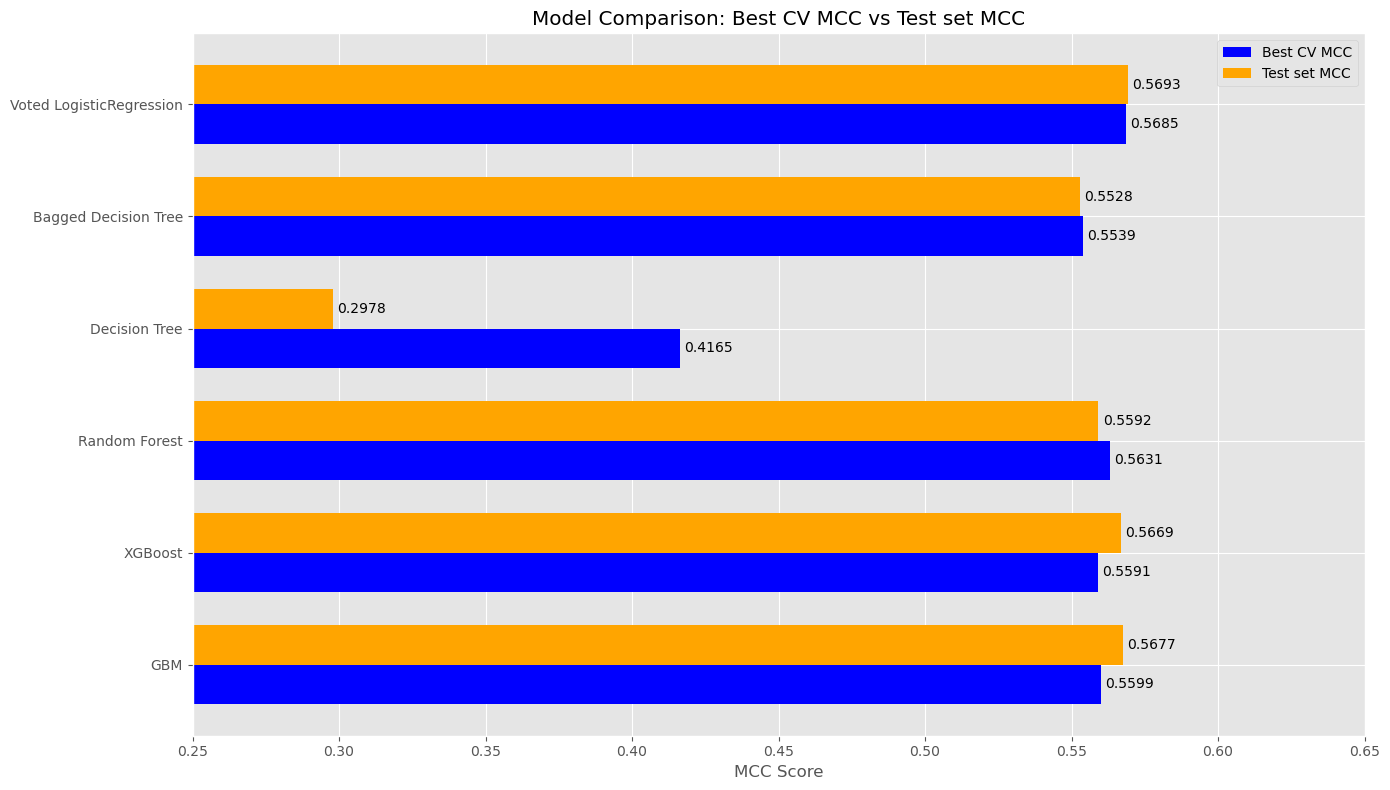

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Assumed result data (please replace with actual results)
models = ['GBM', 'XGBoost', 'Random Forest', 'Decision Tree','Bagged Decision Tree','Voted LogisticRegression']
cv_mcc = [0.5599, 0.5591, 0.5631, 0.4165,0.5539,0.5685]  # Best CV MCC
test_mcc = [0.5677, 0.5669, 0.5592, 0.2978,0.5528,0.5693]  # Test set MCC

# Set up the chart
fig, ax = plt.subplots(figsize=(14, 8))

# Set the positions for the bar chart
y = np.arange(len(models))
height = 0.35

# Create horizontal bar chart, update colors
rects1 = ax.barh(y - height/2, cv_mcc, height, label='Best CV MCC', color='blue')
rects2 = ax.barh(y + height/2, test_mcc, height, label='Test set MCC', color='orange')

# Add some text elements
ax.set_xlabel('MCC Score')
ax.set_title('Model Comparison: Best CV MCC vs Test set MCC')
ax.set_yticks(y)
ax.set_yticklabels(models)
ax.legend()

# Set x-axis range and ticks
ax.set_xlim(0.25, 0.65)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))

# Add specific values on the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.4f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(rects1)
autolabel(rects2)

# Adjust layout and display the chart
fig.tight_layout()
plt.show()

1. Performance ranking:
Voted Logistic Regression and Bagged Decision Tree are the best performing models with very close MCC scores.
GBM and Random Forest performed relatively well but were slightly inferior to the first two models.
Decision Tree lags significantly behind, especially on the test set.
2. Consistency:
The performance of Voted Logistic Regression and Bagged Decision Tree on the cross-validation set and test set is very consistent, indicating that they have better generalization ability on new data.
GBM and Random Forest also show good consistency, with not much difference.
The difference of Decision Tree is large, especially the performance on the test set drops significantly, and there may be over-fitting or under-fitting problems.
3. Best model:
Voted Logistic Regression is the overall best model, with a test set MCC of 0.5685 and a cross-validation set MCC of 0.5693.
Bagged Decision Tree follows closely, with a test set MCC of 0.5539 and a cross-validation set MCC of 0.5528.
4. Model stability:
Ensemble models (such as Voted Logistic Regression and Bagged Decision Tree) generally outperform simple decision trees, indicating that models that combine multiple weak learners have advantages in terms of stability.
5. Potential problems:
A large gap between the cross-validation set and the test set of Decision Tree indicates that the model may need further tuning, or that the simple structure of the model is not sufficient to capture complex patterns.

### Conclusion:
Among the models compared, **Voted Logistic Regression** and **Bagged Decision Tree** emerged as the top performers, demonstrating strong and consistent MCC scores across both cross-validation and test sets. These ensemble methods effectively leverage multiple weak learners, providing more robust and generalized predictions. In contrast, the **Decision Tree** model showed significant underperformance, particularly on the test set, indicating a potential need for further tuning or more advanced model structures. Overall, **Voted Logistic Regression** proved to be the best choice for this task, with **Bagged Decision Tree** offering a close alternative. For future improvements, focusing on tuning the weaker models, especially the simple decision trees, may help reduce the performance gap observed between the CV and test sets.